<a href="https://colab.research.google.com/github/Shujaat123/MUSI_Enhancement_TCMR_CNN/blob/main/MUSI_Enhancement_TCMR_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Medical Ultrasound Image Speckle Reduction and Resolution Enhancement Using Texture Compensated Multi-Resolution Convolution Neural Network**
---

**loading required packages**

In [45]:
!pip install wget
import wget
import os
from keras.models import load_model
from tensorflow.keras.utils import load_img, img_to_array,  plot_model
import matplotlib.pyplot as plt
import numpy as np
import cv2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Loading a pre-trained model

In [ ]:
model_path = 'https://raw.githubusercontent.com/Shujaat123/MUSI_Enhancement_TCMR_CNN/main/32_channel_3x3_MaxPool/32_channel_3x3_trial_0.h5'
model_file = 'model_weights.h5'
if (os.path.exists(model_file)):
  os.remove(model_file)
  wget.download(model_path, model_file)
else:
  wget.download(model_path, model_file)

model = load_model('model_weights.h5')
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True) # Uncomment to see model architecture

Loading sample input image


In [101]:
input_img_path = 'https://raw.githubusercontent.com/Shujaat123/MUSI_Enhancement_TCMR_CNN/main/simulation1.png'
input_file = 'input_img.png'
if (os.path.exists(input_file)):
  os.remove(input_file)
  wget.download(input_img_path, input_file)
else:
  wget.download(input_img_path, input_file)
  
input_img = img_to_array(load_img(input_file, color_mode='grayscale'))
input_img = input_img/255.0
input_img = np.expand_dims(input_img, axis = 0)

output_img = model.predict(input_img, batch_size = 1)



1/1 [==============================] - 1s 953ms/step


Comparison of input V/S output image

Text(0.5, 1.0, 'Output image')

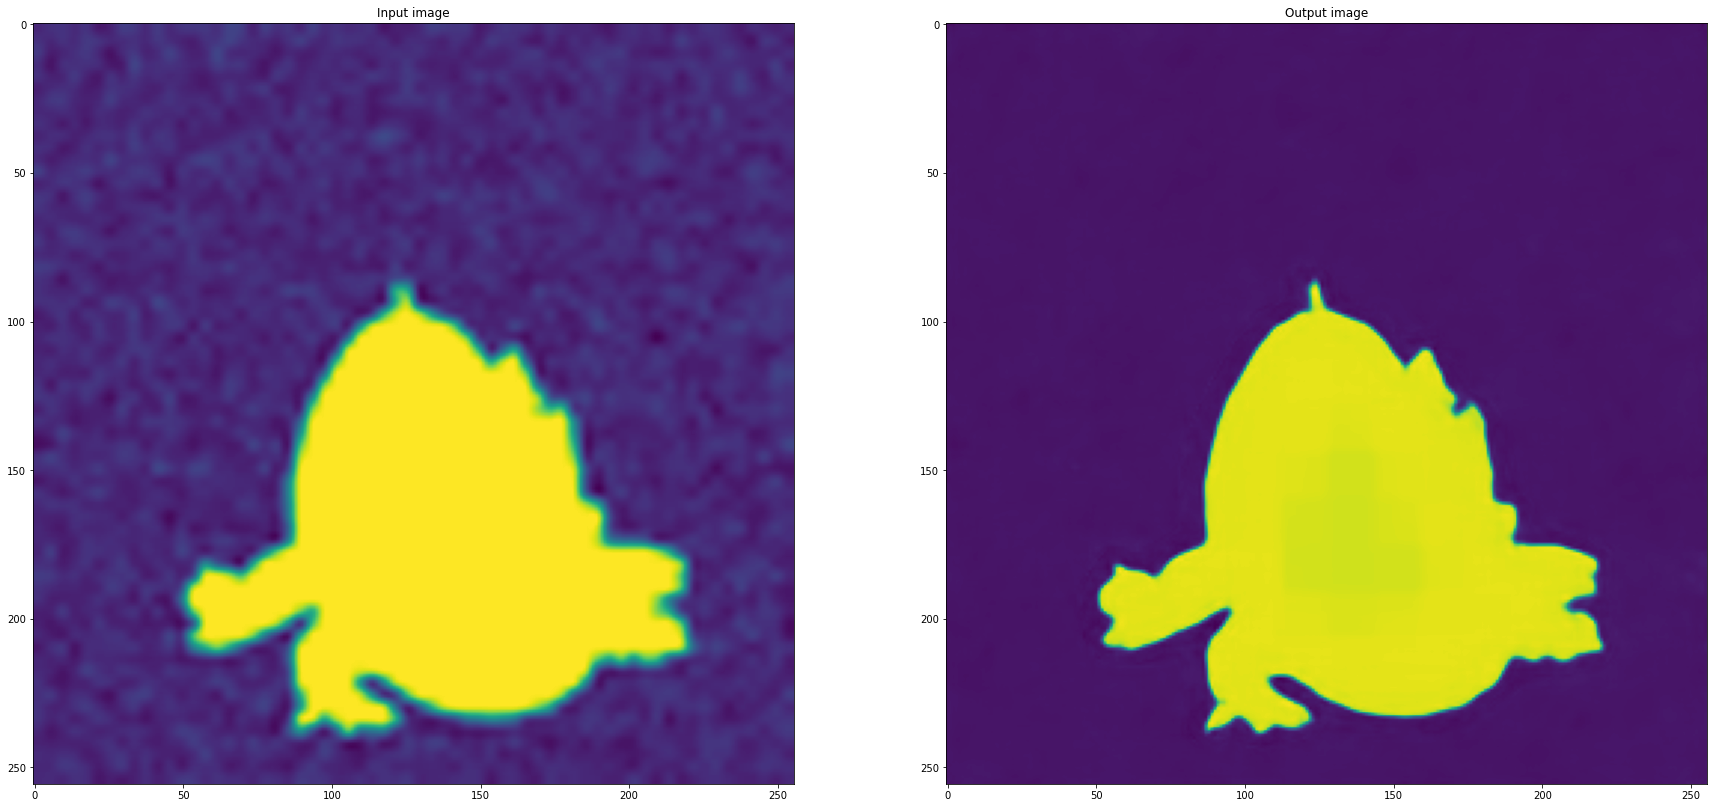

In [102]:
plt.rcParams["figure.figsize"] = (30,30)
plt.figure(1)
plt.subplot(1,2,1)
plt.imshow(input_img.squeeze())
plt.title('Input image')
plt.subplot(1,2,2)
plt.imshow(output_img.squeeze())
plt.title('Output image')